In [1]:
import numpy as np
import pytensor
import pytensor.tensor as pt
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pymc as pm
import csv

random_seed = 1
np.random.seed(random_seed)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [92]:
# simulation parameters
learning_rate=0.0015
bias_strength=2.2
w_init=0.17
gamma=0.8
decision_noise=0.195
representation_noise=0.1

# experiemental value
iSubject=1
nAverage=10
nRandom=100
nConditions=12
nUnits=35
nTrials=9600
Amax=0.5
bias=pt.tile(pt.as_tensor_variable(0, dtype="float64"),nAverage)
bias_update=0.02
w_min=-1
w_max=1
weight=pt.tile(pt.as_tensor_variable(np.array([-45,-30,-15,0,15,30,45], dtype="float64")/30),(nAverage,5))*w_init
#subject group

start_with_right=True

'''
# random sequence
left, right = [0,1,2,3,4,5], [6,7,8,9,10,11]
if start_with_right==True:
    R1,L1,R2,L2,R3,L3 = right*50,left*400,right*400,left*400,right*300,left*50
    random.shuffle(R1)
    random.shuffle(L1)
    random.shuffle(R2)
    random.shuffle(L2)
    random.shuffle(R3)
    random.shuffle(L3)
    test_trial = R1+L1+R2+L2+R3+L3
else:
    L1,R1,L2,R2,L3,R3 = left*50,right*400,left*400,right*400,left*300,right*50
    random.shuffle(L1)
    random.shuffle(R1)
    random.shuffle(L2)
    random.shuffle(R2)
    random.shuffle(L3)
    random.shuffle(R3)
    test_trial = L1+R1+L2+R2+L3+R3
'''

test_trial=pd.read_csv('Simu_data.csv')['Condition'][nTrials*(iSubject-1):nTrials*iSubject].values
contrast=pd.read_csv('Simu_data.csv')['Contrast'][nTrials*(iSubject-1):nTrials*iSubject].values
congruent=pd.read_csv('Simu_data.csv')['Congruent'][nTrials*(iSubject-1):nTrials*iSubject].values
noise_d_seq =  pt.as_tensor_variable(np.random.normal(0, 1, size=(nTrials,nAverage)))*decision_noise
noise_r_seq =  pt.as_tensor_variable(np.random.normal(0, 1, size=(nTrials,nAverage,nUnits)))*representation_noise

In [93]:
'''
# contrast sequence
contrast=np.zeros(9600)
for i in range(nTrials):
    if test_trial[i] in [0,1,6,7]:
        contrast[i]=0.23
    elif test_trial[i] in [2,3,8,9]:
        contrast[i]=0.15
    else:
        contrast[i]=0.10

#Congruent and incongruent sequence
congruent=np.zeros(9600)
for i in range(nTrials):
    if test_trial[i] in [0,2,4,7,9,11]:
        congruent[i]=1
    else:
        congruent[i]=0
'''

# activation sequence
acti = pd.read_csv('Cache2.csv', header=None).values.reshape((nConditions,nRandom, nUnits))

repeat_test_trial=np.tile(test_trial,nAverage)
acti_seq=np.zeros((nAverage*nTrials,nUnits))

random_seq=np.random.randint(0,100,nAverage*nTrials)
for trial_num in range(len(repeat_test_trial)):
    acti_seq[trial_num]=acti[test_trial[trial_num%nTrials]][random_seq[trial_num%nTrials]]
acti_seq=pt.as_tensor_variable(acti_seq.reshape((nTrials, nAverage, nUnits), order='F'))

acti_withnoise = acti_seq+noise_r_seq
acti_normalized =((1-pt.exp(-gamma*pt.switch(acti_withnoise>0,acti_withnoise,0)))/(1+pt.exp(-gamma*pt.switch(acti_withnoise>0,acti_withnoise,0))))*Amax

# sign sequence
sign = [-1,1,-1,1,-1,1,-1,1,-1,1,-1,1]
sign_seq = pt.as_tensor_variable([sign[condi] for condi in test_trial], dtype="float64")



In [95]:
def update_decisions(acti_normalized, noise_d_seq, sign_seq, bias, weight):
    # calculate sign of decision
    decision=pt.sum(acti_normalized*weight,axis=1) - bias_strength * bias + noise_d_seq
    decision=decision/pt.abs(decision)

    # update bias and weight
    bias= bias_update*decision+(1-bias_update)*bias
    delta=acti_normalized*learning_rate*sign_seq*Amax
    weight=weight+(w_max-weight)*pt.switch(delta>=0,delta,0)+(weight-w_min)*pt.switch(delta<0,delta,0)
    
    return bias, weight, decision    

In [96]:
results, _ = pytensor.scan(fn=update_decisions,
                         sequences=[acti_normalized, noise_d_seq, sign_seq],
                         outputs_info=[bias,weight, None])

avg_decision=results[2]
correctness=(avg_decision.sum(axis=1)/nAverage)*sign_seq

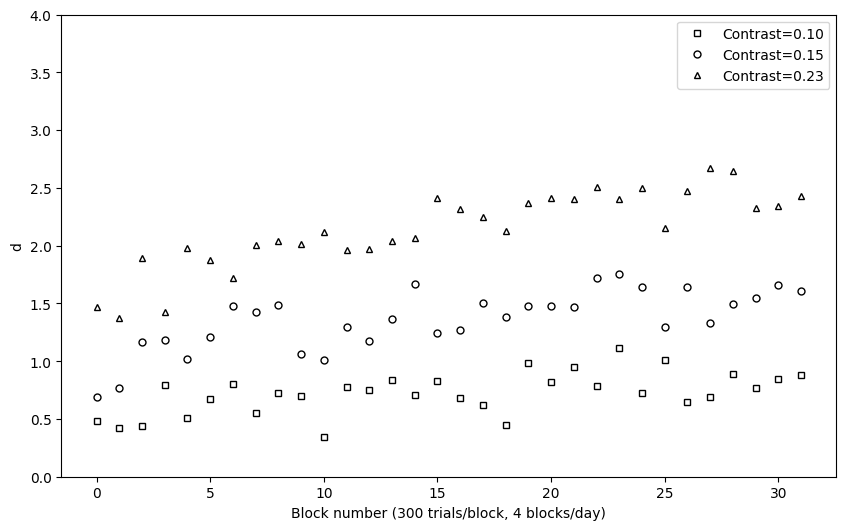

In [97]:
prob=pm.draw((correctness+1)/2)

low=prob[np.where(contrast==0.1)].reshape((32,100)).sum(axis=1)/100
normal=prob[np.where(contrast==0.15)].reshape((32,100)).sum(axis=1)/100
high=prob[np.where(contrast==0.23)].reshape((32,100)).sum(axis=1)/100

d_low=stats.norm.ppf(low)-stats.norm.ppf(1-low)
d_normal=stats.norm.ppf(normal)-stats.norm.ppf(1-normal)
d_high=stats.norm.ppf(high)-stats.norm.ppf(1-high)

fig = plt.figure(figsize=(10, 6))
plt.plot(d_low, color='black', marker='s', markersize=5, linestyle='',markerfacecolor='none', label='Contrast=0.10')
plt.plot(d_normal, color='black', marker='o', markersize=5, linestyle='',markerfacecolor='none', label='Contrast=0.15')
plt.plot(d_high, color='black', marker='^', markersize=5, linestyle='',markerfacecolor='none', label='Contrast=0.23')
plt.ylabel('d')
plt.xlabel('Block number (300 trials/block, 4 blocks/day)')
plt.ylim(0,4)
plt.legend()

plt.savefig(f'simulation/learning_curve/random_seed = {random_seed}',bbox_inches='tight')
plt.show()

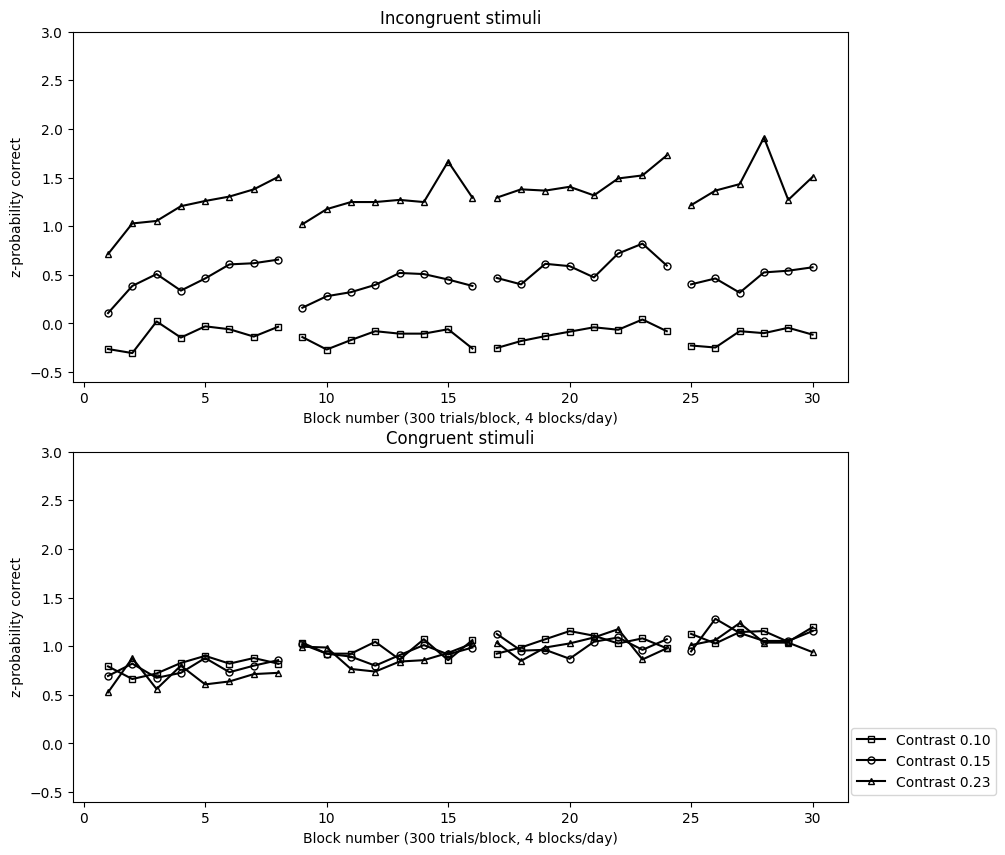

In [98]:
#congruent and incongruent

title={0:'Incongruent stimuli', 1: 'Congruent stimuli'}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
axes=[ax1,ax2]
for i in [0,1]:
    low=prob[np.intersect1d(np.where(contrast==0.1),np.where(congruent==i))].reshape((32,50)).sum(axis=1)/50
    normal=prob[np.intersect1d(np.where(contrast==0.15),np.where(congruent==i))].reshape((32,50)).sum(axis=1)/50
    high=prob[np.intersect1d(np.where(contrast==0.23),np.where(congruent==i))].reshape((32,50)).sum(axis=1)/50

    z_low,z_normal,z_high= stats.norm.ppf(low), stats.norm.ppf(normal), stats.norm.ppf(high)
    
    start=[1,9,17,25,31]
    for j in range(4):
        low_part, normal_part, high_part=z_low[start[j]:start[j+1]],z_normal[start[j]:start[j+1]],z_high[start[j]:start[j+1]]
        axes[i].plot(np.arange(start[j],start[j+1]),low_part, color='black', marker='s', markersize=5, markerfacecolor='none',markeredgewidth=1)
        axes[i].plot(np.arange(start[j],start[j+1]),normal_part, color='black', marker='o', markersize=5, markerfacecolor='none',markeredgewidth=1)
        axes[i].plot(np.arange(start[j],start[j+1]),high_part, color='black', marker='^',markersize=5, markerfacecolor='none',markeredgewidth=1)

    axes[i].set_ylabel('z-probability correct')
    axes[i].set_xlabel('Block number (300 trials/block, 4 blocks/day)')
    axes[i].set_title(title.get(i))
    axes[i].set_ylim(-0.6,3)
    
legend_handles = [plt.Line2D([],[],marker='s',color='black',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10'),
                  plt.Line2D([],[],marker='o',color='black',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15'),
                  plt.Line2D([],[],marker='^',color='black',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23')]
plt.legend(handles=legend_handles, loc='lower right',bbox_to_anchor=(1.2, 0))
plt.savefig(f'simulation/congruent and incongruent/random_seed = {random_seed}',bbox_inches='tight')
plt.show()




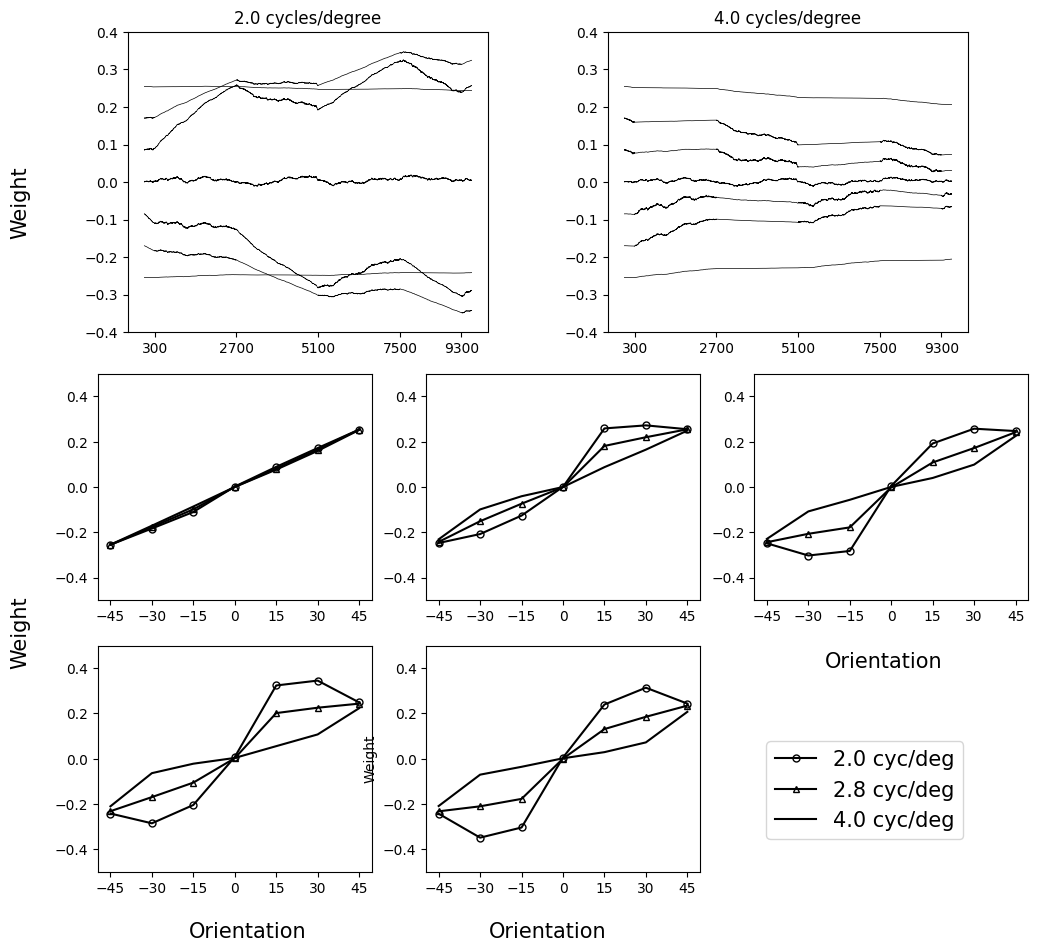

In [74]:
# generate weight change

w=pm.draw(results[1][:,0,:])
weight=[]
for i in [299,2699,5099,7499,9299]:    
    weight.append((w[i]))

fig,((ax1, ax_none_1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax_none_2)) = plt.subplots(3, 3, figsize=(12, 10))
fig.delaxes(ax_none_1)
fig.delaxes(ax_none_2)

axes=[ax1, ax2]
cycle = [w[:, np.arange(14, 21)], w[:, np.arange(28, 35)]]
freqency=[2.0,4.0]
ax1.set_position([0.15,0.65,0.3,0.3])
ax2.set_position([0.55,0.65,0.3,0.3])

for i in range(2):
    for j in range(7):
        axes[i].plot(cycle[i][:, j], color='black',  linewidth=0.5)
        axes[i].set_title(f'{freqency[i]} cycles/degree')
        axes[i].set_xticks([300,2700,5100,7500,9300])
        axes[i].set_ylim(-0.4,0.4)
    plt.ylabel('Weight')

#contest switch
axes=[ax3, ax4, ax5, ax6, ax7]
marker=['o','^','None']
label=['2.0 cyc/deg','2.8 cyc/deg','4.0 cyc/deg']
weight_arr=[[],[],[],[],[]]
context=['L','R','L','R','L']
trial=[300,2700,5100,7500,9300]
for i in range(5):
    for j in range(3):
    #frequency 2.0, 2.8, 4.0
        weight_arr=[[],[],[],[],[]]
        weight_arr[i]=weight[i][(j+2)*7+np.arange(7)]
        axes[i].plot(np.arange(-3,4)*15, weight_arr[i], marker=marker[j], markerfacecolor='none',markeredgewidth=1,markersize=5, color='black',label=label[j])
        axes[i].set_xticks([-45,-30,-15,0,15,30,45])
        axes[i].set_ylim(-0.5,0.5)
ax7.legend(loc='lower right', bbox_to_anchor=(2,0.1), fontsize=15)
fig.text(0.25, 0.05, 'Orientation', ha='center', va='center', fontsize=15)
fig.text(0.5, 0.05, 'Orientation', ha='center', va='center', fontsize=15)
fig.text(0.78, 0.32, 'Orientation', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.35, 'Weight', ha='center', va='center', rotation='vertical',fontsize=15)
fig.text(0.06, 0.78, 'Weight', ha='center', va='center', rotation='vertical',fontsize=15)
plt.savefig(f'simulation/weight/random_seed = {random_seed}',bbox_inches='tight')
plt.show()
    

In [ ]:
'''
iSubject=np.ones(9600)*random_seed
direction=pm.draw(decision_seq[2])
data=np.stack([iSubject,test_trial, Response,congruent,contrast],axis=1)

csv_file_path = "Simu_data_re.csv"
# Write the data to the CSV file
with open(csv_file_path, 'a', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['subject','condition','response','congruent','contrast'])
    for row in data:
        csvwriter.writerow(row)
'''